- clean tweets:
    - https (done)
    - pics (done)
    - diff languages?
    - clean ellipses (done)
    - remove query hashtags, keep other hashtags (done)

- lemmatize  (done)



- tf idf nmf- clusters - use svd to find elbow (done)
- count vectorizer(majority vote) - lda (done?)



- sentiment analysis (done-ish)
- word2vec (also look into doc2vec)
    -create corpus of all tweets (listify the dataframe column)


# Imports

In [1]:
import numpy as np
from PIL import Image
from datetime import datetime, timedelta
import pandas as pd
pd.set_option('max_colwidth',1000)
from pymongo import MongoClient
import nltk
import re
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

#NLP 
from collections import Counter
from gensim import corpora, models, similarities, matutils
from googletrans import Translator
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import TruncatedSVD, NMF
from sklearn.preprocessing import Normalizer
from sklearn import metrics
from sklearn.cluster import KMeans, MiniBatchKMeans, DBSCAN
from sklearn.utils.extmath import randomized_svd
from nltk.corpus import stopwords
import gensim
from sklearn.manifold import TSNE
from wordcloud import WordCloud, ImageColorGenerator

# Reading and Cleaning Data

In [2]:
client = MongoClient()
db = client.gunControl
col = db.tweets

In [3]:
col.count()

292484

In [4]:
df = pd.DataFrame(list(col.find())) # set limit for now

In [5]:
df.drop('_id', axis = 1, inplace = True) # drop mongodb id

In [6]:
df.event.value_counts() #check how many tweets for each event

parkland         71025
orlando          49196
sanbernardino    43153
lasvegas         43088
texaschurch      33460
sandyhook        27805
navyyard         17032
aurora            7725
Name: event, dtype: int64

In [7]:
#these rows had incorrect dates.
rowsClean = [196769, 196773, 207063, 207065, 227653, 227655, 218654, 208562, 181759]
for row in rowsClean:
    df.drop(row, inplace = True)
df.reset_index();

### Cleaning tweets

In [8]:
df['tweet'] = df.text.apply(lambda x: re.sub('https?:\/\/\S*', "",x))
df['tweet'] = df.tweet.apply(lambda x: re.sub('(?:pic\.).*', "", x))
df['tweet'] = df.tweet.apply(lambda x: re.sub('…', "", x))
#df['tweet'] = df.tweet.apply(lambda x: re.sub("@ *\S*", "", x))
df['tweet'] = df.tweet.apply(lambda x: x.strip())

In [9]:
df['test'] = df.tweet.apply(lambda x: re.sub('(#|@) *\S*','',x))
df['lentest'] = df.test.apply(lambda x: len(' '.join(x.split()).split(' ')))
df = df[df.lentest > 5]
df.drop(['test', 'lentest'], inplace = True, axis = 1)

In [10]:
df.reset_index(drop=True);

In [11]:
replaceList = ["# guncontrolnow", "# guncontrol", "# gunreformnow", "# gunreform", "# 2a", "# nra", 
               "# gunrights", "# gunsense", "# parkland", "# texaschurch", "# lasvegas", "# orlando",
               "# sanbernardino", "# navyyard", "# sandyhook", "# aurora"]

df['tweet_nohashtag'] = df.tweet
for hashtag in replaceList:
    df['tweet_nohashtag'] = df.tweet_nohashtag.apply(lambda x: re.sub(hashtag + "($|\s|[^a-zA-Z\d])", "", x.lower()))

df['tweet'] = df.tweet.apply(lambda x: re.sub(r'[^\w\s]','',x))
df['tweet_nohashtag'] = df.tweet_nohashtag.apply(lambda x: re.sub(r'[^\w\s]','',x))

### Lemmatize - doesn't improve topic modeling

In [3]:
from textblob import TextBlob
lemma = nltk.stem.WordNetLemmatizer()

In [505]:
df['lemma_tweet'] = df.tweet.apply(lambda x: ' '.join((lemma.lemmatize(word) for word in TextBlob(x).words)));
df['lemma_tweet_nohashtag'] = df.tweet_nohashtag.apply(lambda x: ' '.join((lemma.lemmatize(word) for word in TextBlob(x).words)));

In [29]:
#use to spot check data

df[df['tweet_nohashtag'].str.contains("gunreformnow")]

,ID,date,event,favorites,retweets,text,username,tweet,tweet_nohashtag,vaderNeu,vaderPos,vaderNeg,vaderComp
6229,965355820040015872,2018-02-18 22:42:17,parkland,4,4,"It's NOT the gun. Under Obama rule, we saw a drastic increase in mass murder over any previous Administration. # GunControlNO # GunReformNowNOT # ObamaGateYES # ObamaGateExposedhttps://freedomoutpost.com/obama-progressive-left-responsible-mass-shootings-not-guns/ …",EarlShayOFAGa,Its NOT the gun Under Obama rule we saw a drastic increase in mass murder over any previous Administration GunControlNO GunReformNowNOT ObamaGateYES ObamaGateExposed,its not the gun under obama rule we saw a drastic increase in mass murder over any previous administration guncontrolno gunreformnownot obamagateyes obamagateexposed,0.678,0.155,0.168,-0.3322
8959,965585281750568960,2018-02-19 13:54:05,parkland,1,0,So is the 2018 millennial and gen z experience just coaching friends and family through what to say to the press just in case something ever happens to you? GunReformNow # guncontrol,collins1129,So is the 2018 millennial and gen z experience just coaching friends and family through what to say to the press just in case something ever happens to you GunReformNow guncontrol,so is the 2018 millennial and gen z experience just coaching friends and family through what to say to the press just in case something ever happens to you gunreformnow,0.900,0.100,0.000,0.4767
14146,964624293329022978,2018-02-16 22:15:28,parkland,1,0,Cowardly? Huh. Let's talk about Trump who's taken blood money from the NRA who in turn aids and abets white supremacists like the monster who killed 17 innocent kids in school. Let's have knee jerk reactions! # CowardlyTrump # GunControlNow # StoptheNRA # EnoughTalkGunReformNow,OhSweetCinna,Cowardly Huh Lets talk about Trump whos taken blood money from the NRA who in turn aids and abets white supremacists like the monster who killed 17 innocent kids in school Lets have knee jerk reactions CowardlyTrump GunControlNow StoptheNRA EnoughTalkGunReformNow,cowardly huh lets talk about trump whos taken blood money from the nra who in turn aids and abets white supremacists like the monster who killed 17 innocent kids in school lets have knee jerk reactions cowardlytrump stopthenra enoughtalkgunreformnow,0.668,0.099,0.233,-0.7650
22508,964493900512710657,2018-02-16 13:37:19,parkland,1,1,Congratulations @ MittRomney on your senate run! I hope the 2004 version of you on # GunReform shows up and not the guy who flipfloped during your presidential campaign. Looking to you sir to keep us safe!! # MittRomney # SensibleGunReformNOW,susudahl,Congratulations MittRomney on your senate run I hope the 2004 version of you on GunReform shows up and not the guy who flipfloped during your presidential campaign Looking to you sir to keep us safe MittRomney SensibleGunReformNOW,congratulations mittromney on your senate run i hope the 2004 version of you on shows up and not the guy who flipfloped during your presidential campaign looking to you sir to keep us safe mittromney sensiblegunreformnow,0.767,0.233,0.000,0.8658
30425,965355820040015872,2018-02-18 22:42:17,parkland,4,4,"It's NOT the gun. Under Obama rule, we saw a drastic increase in mass murder over any previous Administration. # GunControlNO # GunReformNowNOT # ObamaGateYES # ObamaGateExposedhttps://freedomoutpost.com/obama-progressive-left-responsible-mass-shootings-not-guns/ …",EarlShayOFAGa,Its NOT the gun Under Obama rule we saw a drastic increase in mass murder over any previous Administration GunControlNO GunReformNowNOT ObamaGateYES ObamaGateExposed,its not the gun under obama rule we saw a drastic increase in mass murder over any previous administration guncontrolno gunreformnownot obamagateyes obamagateexposed,0.678,0.155,0.168,-0.3322
32093,965708547702050816,2018-02-19 22:03:54,parkland,26,11,"We heard you loud and clear at last weeks Gun Reform Meeting. Join us, @ MayorLevine , and @ womensmarch Florida chapter as we storm t

### Vader Sentiment

In [329]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

In [330]:
analyzer = SentimentIntensityAnalyzer()

In [331]:
#lemma_tweet_list = list(df.lemma_tweet)
tweet_nohtag_list = list(df.tweet_nohashtag)

In [332]:
analyzer = SentimentIntensityAnalyzer()
neuList = []
posList = []
negList = []
compList = []
for tweet in tweet_nohtag_list:
    vs = analyzer.polarity_scores(tweet)
    neuList.append(vs['neu'])
    posList.append(vs['pos'])
    negList.append(vs['neg'])
    compList.append(vs['compound'])


In [333]:
df['vaderNeu'] = neuList
df['vaderPos'] = posList
df['vaderNeg'] = negList
df['vaderComp'] = compList

## WORD CLOUD

In [12]:
stop = stopwords.words('english')
stop += ['.', ',', '(',')', "'", '"', 'need', 'dont', 'ha', 'wa', 'get', 'want', 'take', 'make']
stop=set(stop)

In [335]:
negtweets = df[df["vaderNeg"] > df["vaderPos"]]
postweets = df[df["vaderNeg"] < df["vaderPos"]]
negtext = pd.Series(negtweets.tweet).str.cat(sep=' ')
postext = pd.Series(postweets.tweet).str.cat(sep=' ')

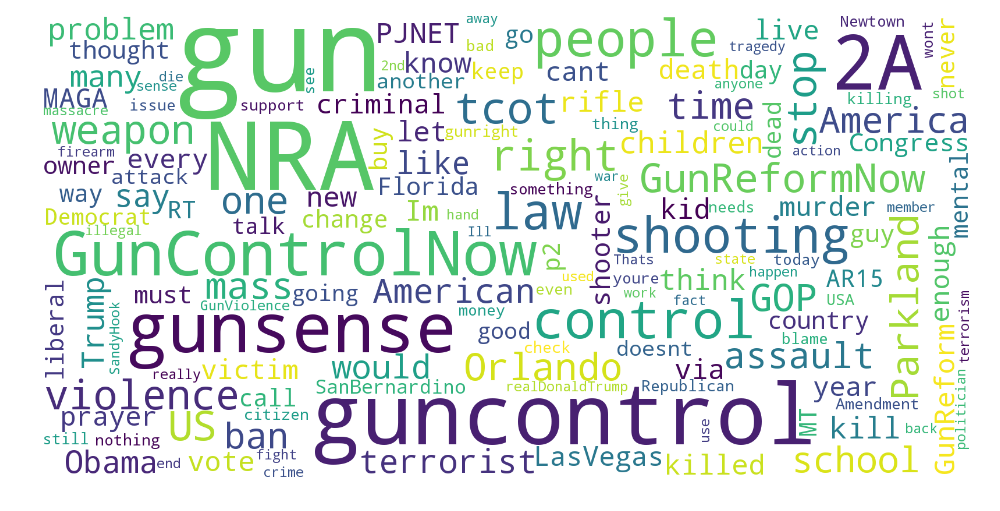

In [336]:
#NEGATIVE WORDCLOUD

wordcloud = WordCloud(width=1600, height=800,max_font_size=200, max_words = 150,
                      stopwords = stop, random_state = 42, collocations = False, background_color = 'white').generate(negtext)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

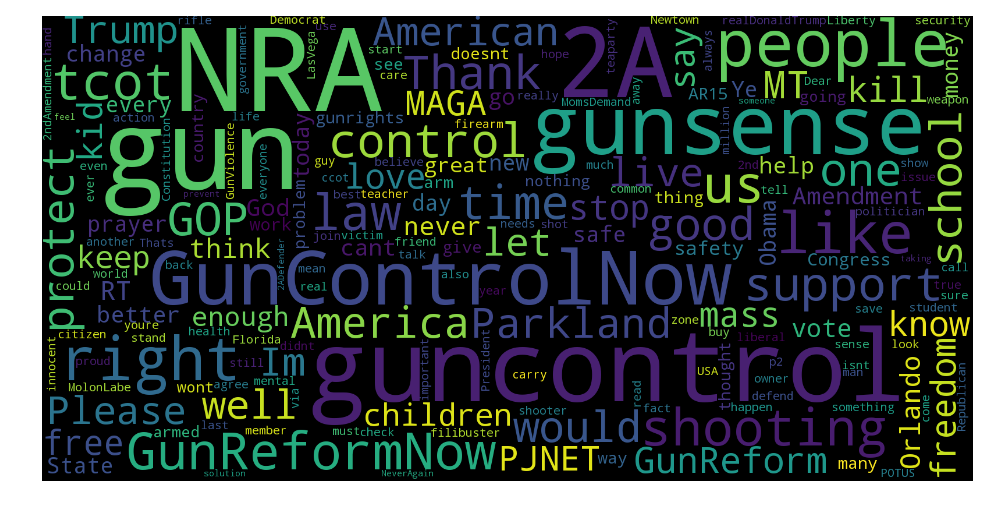

In [337]:
#POSITIVE WORDCLOUD
wordcloud = WordCloud(width=1600, height=800,max_font_size=200, 
                      stopwords = stop, random_state = 42, collocations = False).generate(postext)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

### SENTIMENT PLOTTING

In [338]:
df_grouped = df.groupby([df['date'].dt.date, df['event']]).mean().dropna().reset_index()

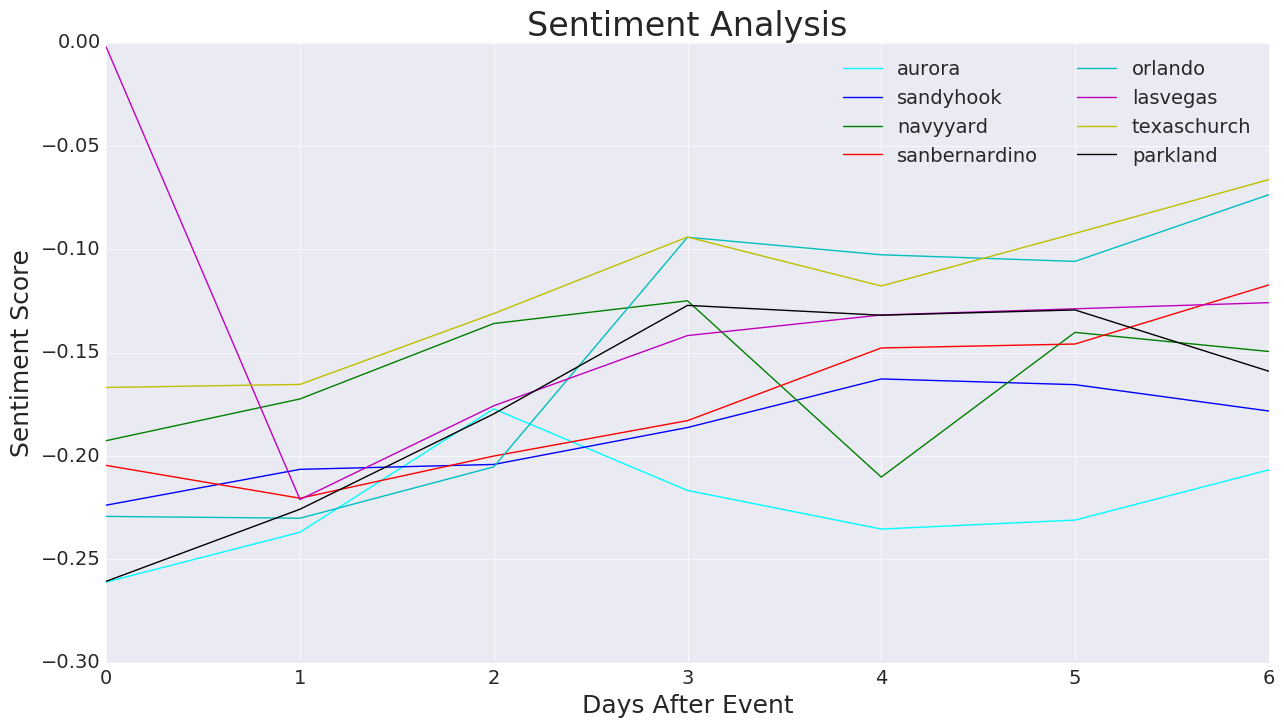

In [339]:
plt.figure(figsize=(15,8))
sns.set_style("darkgrid")
#plt.plot(df_grouped.date, df_grouped.vaderNeg, color = 'r', label = 'negative')
#plt.plot(df_grouped.date, df_grouped.vaderPos, color = 'g', label = 'positive')
plt.plot(range(0,7), df_grouped[df_grouped['event'] == 'aurora'].vaderComp, color = 'aqua', label = 'aurora')
plt.plot(range(0,7), df_grouped[df_grouped['event'] == 'sandyhook'].vaderComp, label = 'sandyhook')
plt.plot(range(0,7), df_grouped[df_grouped['event'] == 'navyyard'].vaderComp, label = 'navyyard')
plt.plot(range(0,7), df_grouped[df_grouped['event'] == 'sanbernardino'].vaderComp, label = 'sanbernardino')
plt.plot(range(0,7), df_grouped[df_grouped['event'] == 'orlando'].vaderComp, label = 'orlando')
plt.plot(range(0,7), df_grouped[df_grouped['event'] == 'lasvegas'].vaderComp, label = 'lasvegas')
plt.plot(range(0,7), df_grouped[df_grouped['event'] == 'texaschurch'].vaderComp, label = 'texaschurch')
plt.plot(range(0,7), df_grouped[df_grouped['event'] == 'parkland'].vaderComp, label = 'parkland')
plt.legend(loc="best", ncol = 2, fontsize = 14)
plt.title("Sentiment Analysis", fontsize = 24)
plt.xlabel("Days After Event", fontsize = 18)
plt.ylabel("Sentiment Score", fontsize = 18)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.show()

## SENTIMENT PLOTTING - by Cluster

In [378]:
df_sentiment_grouped = df.groupby([df['date'].dt.date, df['event'], df['cluster']]).mean().dropna().reset_index()

In [385]:
day = []
for i in range(0,7):
    day.append(i)
    day.append(i)
    day.append(i)
    day.append(i)
day = day*8

In [396]:
df_sentiment_grouped['day'] = day
df_sentiment_grouped;

In [398]:
df_sentiment_grouped = df_sentiment_grouped.groupby([df_sentiment_grouped['cluster'],
                                                    df_sentiment_grouped['day']]).mean().dropna().reset_index()

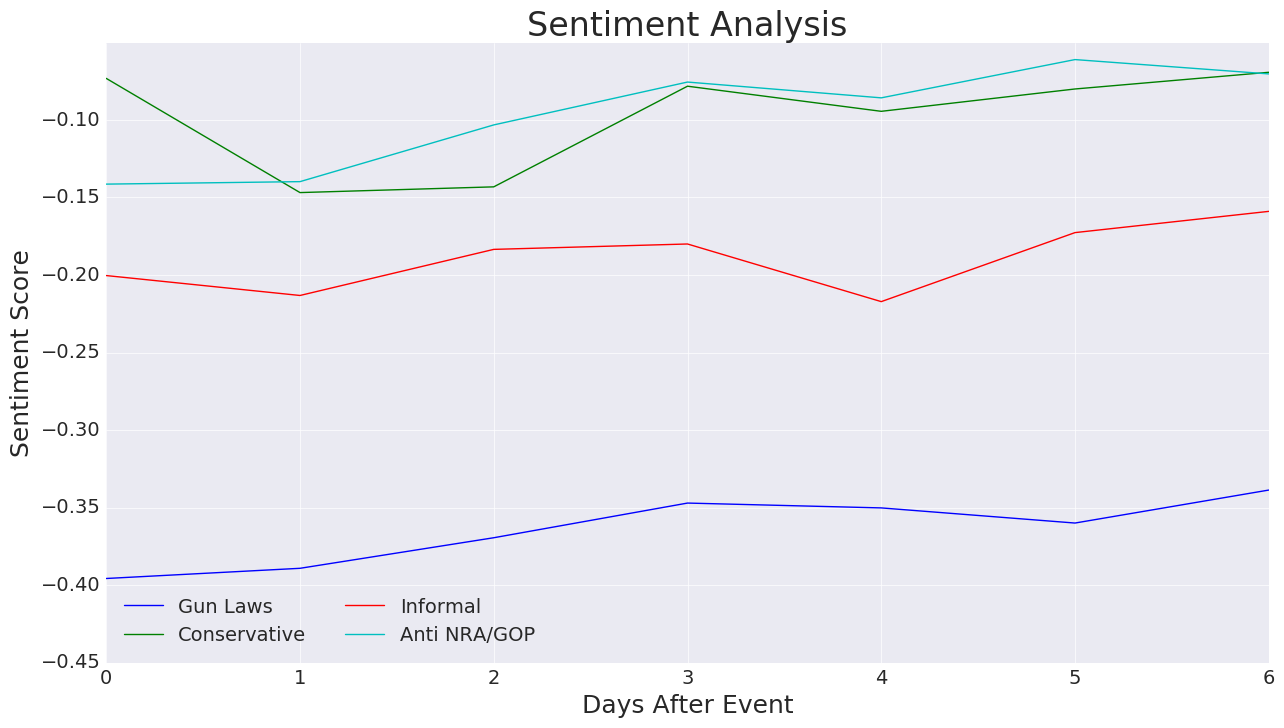

In [445]:
plt.figure(figsize=(15,8))
sns.set_style("darkgrid")
plt.plot(range(0,7), df_sentiment_grouped[df_sentiment_grouped['cluster'] == 0].vaderComp, label = 'Gun Laws')
plt.plot(range(0,7), df_sentiment_grouped[df_sentiment_grouped['cluster'] == 1].vaderComp, label = 'Conservative')
plt.plot(range(0,7), df_sentiment_grouped[df_sentiment_grouped['cluster'] == 2].vaderComp, label = 'Informal')
plt.plot(range(0,7), df_sentiment_grouped[df_sentiment_grouped['cluster'] == 3].vaderComp, label = 'Anti NRA/GOP')
plt.legend(loc="best", ncol = 2, fontsize = 14)
plt.title("Sentiment Analysis", fontsize = 24)
plt.xlabel("Days After Event", fontsize = 18)
plt.ylabel("Sentiment Score", fontsize = 18)
plt.ylim(-0.45, -0.05)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.show()

### By President

In [417]:
obama = df[df.date < '2016-12-08']
trump = df[df.date > '2016-12-08']

OBAMA

In [436]:
obama.sort_values(by='vaderComp')

,ID,date,event,favorites,retweets,text,username,tweet,tweet_nohashtag,vaderNeu,vaderPos,vaderNeg,vaderComp,cluster
234377,673583694238601217,2015-12-06 19:24:01,sanbernardino,1,2,Ny Jets suck Giants SUCK # Yankees SUCK Rangers SUCK Knicks SUCK Mets SUCK devils SUCK # Nets SUCK Islanders SUCK trump SUCKS # nra SUCKS,JerryManderMan,Ny Jets suck Giants SUCK Yankees SUCK Rangers SUCK Knicks SUCK Mets SUCK devils SUCK Nets SUCK Islanders SUCK trump SUCKS nra SUCKS,ny jets suck giants suck yankees suck rangers suck knicks suck mets suck devils suck nets suck islanders suck trump sucks sucks,0.223,0.000,0.777,-0.9859,1
239602,673222341187403776,2015-12-05 19:28:08,sanbernardino,1,0,All terrorists are criminals but not all criminals are terrorists. Gun laws hinder some criminals but very few terrorists. # SanBernardino,TheValuesVoter,All terrorists are criminals but not all criminals are terrorists Gun laws hinder some criminals but very few terrorists SanBernardino,all terrorists are criminals but not all criminals are terrorists gun laws hinder some criminals but very few terrorists,0.290,0.000,0.710,-0.9854,0
148595,742079468857139200,2016-06-12 19:41:47,orlando,4,3,# Florida terrorist mass murderer maybe lone wolf # ISIS supporter but hated gay ppl+made this uniquely horrific hate crime # LGBT # guncontrol,RonanLTynan,Florida terrorist mass murderer maybe lone wolf ISIS supporter but hated gay pplmade this uniquely horrific hate crime LGBT guncontrol,florida terrorist mass murderer maybe lone wolf isis supporter but hated gay pplmade this uniquely horrific hate crime lgbt,0.265,0.037,0.697,-0.9839,3
228567,672151983436922880,2015-12-02 20:34:55,sanbernardino,2,2,@ dkmkc2000 Yes. My heart weeps for the victims but I am fighting mad that goverment blames guns instead of evil. Evil is the problem. # NRA,PhillipLaird,dkmkc2000 Yes My heart weeps for the victims but I am fighting mad that goverment blames guns instead of evil Evil is the problem NRA,dkmkc2000 yes my heart weeps for the victims but i am fighting mad that goverment blames guns instead of evil evil is the problem,0.304,0.040,0.656,-0.9839,2
238923,672261601593073664,2015-12-03 03:50:30,sanbernardino,1,1,Terror is terror. Dead is dead. Gun violence is just as violent no matter who is pulling the trigger. This needs to stop. # SanBernardino,TallyAnnaE,Terror is terror Dead is dead Gun violence is just as violent no matter who is pulling the trigger This needs to stop SanBernardino,terror is terror dead is dead gun violence is just as violent no matter who is pulling the trigger this needs to stop,0.293,0.025,0.682,-0.9836,0
221615,672759761272614912,2015-12-04 12:50:01,sanbernardino,2,1,". @ DougAndTRae, # Leftist # Democrats use "" # gun violence"" & ""gun murder"" propaganda terms bc they hate # guns, not violence & murder. # 2A # tcot",MikeRobbinsUSA,DougAndTRae Leftist Democrats use gun violence gun murder propaganda terms bc they hate guns not violence murder 2A tcot,dougandtrae leftist democrats use gun violence gun murder propaganda terms bc they hate guns not violence murder tcot,0.262,0.000,0.738,-0.9819,0
221605,672761725020536832,2015-12-04 12:57:49,sanbernardino,1,1,"# Leftist # Democrats use "" # gun violence"" & ""gun murder"" propaganda terms bc they hate # guns, not violence & murder. # 2A # tpot # tcot # tlot # p2",MikeRobbinsUSA,Leftist Democrats use gun violence gun murder propaganda terms bc they hate guns not violence murder 2A tpot tcot tlot p2,leftist democrats use gun violence gun murder propaganda terms bc they hate guns not violence murder tpot tcot tlot p2,0.299,0.000,0.701,-0.9819,0
205644,672158788191940608,2015-12-02 21:01:57,sanbernardino,3,1,Fuck Guns. Fuck Hatred. Fuck Violence. And FUCK THE NRA!! I am so over this shit. # guncontrolnow,DorothyFarias1,Fuck Guns Fuck Hatred Fuck Violence And FUCK THE NRA I am so over this shit guncontrolnow,fuck guns fuck hatred fuck violence and fuck the nra i am so over this shit,0.229,0.000,0.771,-0.9815,2

In [419]:
obama_sentiment_grouped = obama.groupby([obama['date'].dt.date, obama['event'], obama['cluster']]).mean().dropna().reset_index()

In [420]:
day = []
for i in range(0,7):
    day.append(i)
    day.append(i)
    day.append(i)
    day.append(i)
day = day*5

In [422]:
obama_sentiment_grouped['day'] = day
obama_sentiment_grouped;

In [425]:
obama_sentiment_grouped = obama_sentiment_grouped.groupby([obama_sentiment_grouped['cluster'],
                                                    obama_sentiment_grouped['day']]).mean().dropna().reset_index()

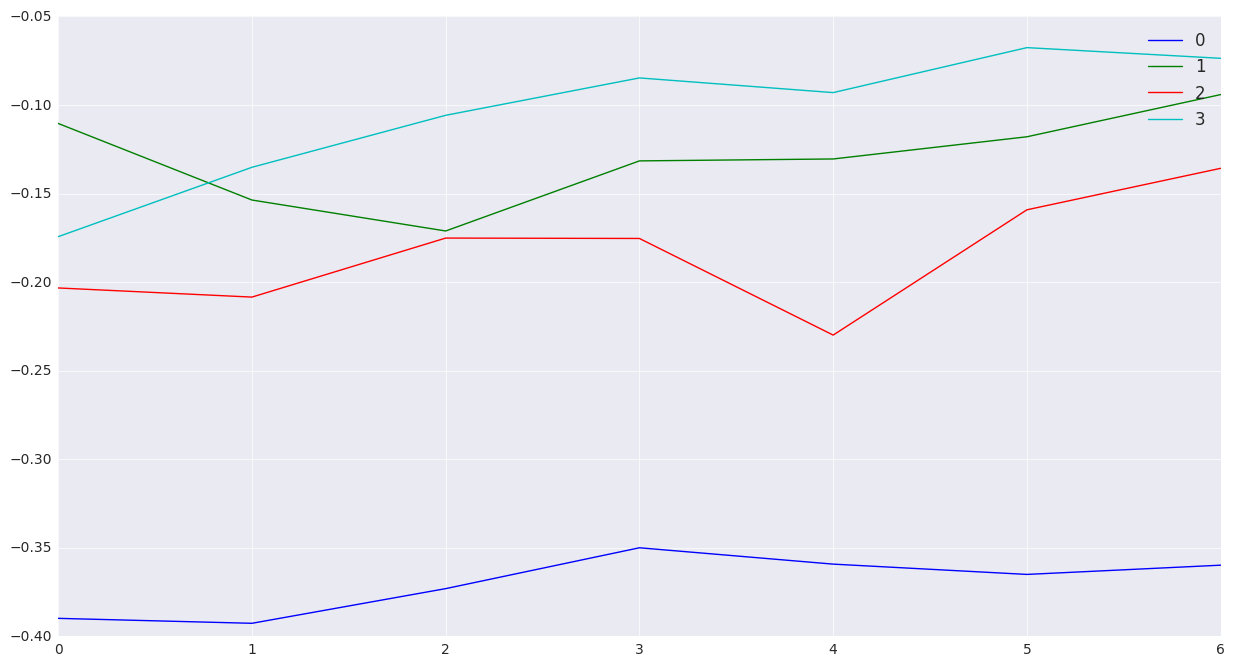

In [426]:
plt.figure(figsize=(15,8))
sns.set_style("darkgrid")
plt.plot(range(0,7), obama_sentiment_grouped[obama_sentiment_grouped['cluster'] == 0].vaderComp, label = '0')
plt.plot(range(0,7), obama_sentiment_grouped[obama_sentiment_grouped['cluster'] == 1].vaderComp, label = '1')
plt.plot(range(0,7), obama_sentiment_grouped[obama_sentiment_grouped['cluster'] == 2].vaderComp, label = '2')
plt.plot(range(0,7), obama_sentiment_grouped[obama_sentiment_grouped['cluster'] == 3].vaderComp, label = '3')
plt.legend()
plt.show()

TRUMP

In [427]:
trump_sentiment_grouped = trump.groupby([trump['date'].dt.date, trump['event'], trump['cluster']]).mean().dropna().reset_index()

In [428]:
day = []
for i in range(0,7):
    day.append(i)
    day.append(i)
    day.append(i)
    day.append(i)
day = day*3

In [431]:
trump_sentiment_grouped['day'] = day
trump_sentiment_grouped;

In [432]:
trump_sentiment_grouped = trump_sentiment_grouped.groupby([trump_sentiment_grouped['cluster'],
                                                    trump_sentiment_grouped['day']]).mean().dropna().reset_index()

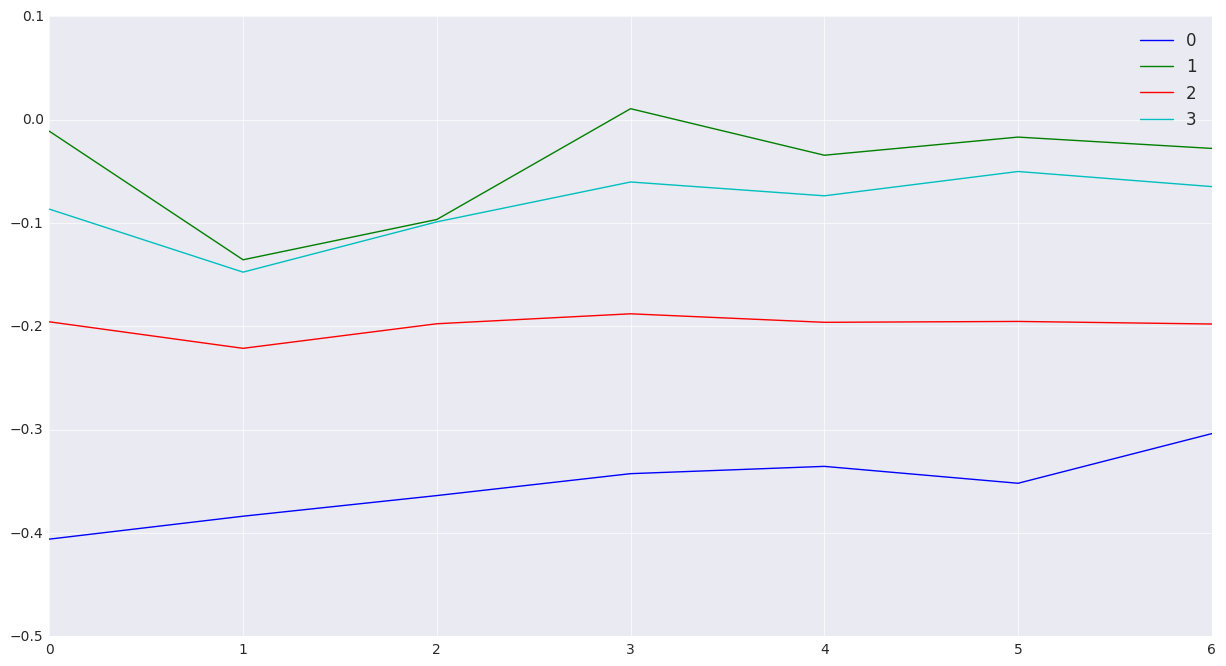

In [433]:
plt.figure(figsize=(15,8))
sns.set_style("darkgrid")
plt.plot(range(0,7), trump_sentiment_grouped[trump_sentiment_grouped['cluster'] == 0].vaderComp, label = '0')
plt.plot(range(0,7), trump_sentiment_grouped[trump_sentiment_grouped['cluster'] == 1].vaderComp, label = '1')
plt.plot(range(0,7), trump_sentiment_grouped[trump_sentiment_grouped['cluster'] == 2].vaderComp, label = '2')
plt.plot(range(0,7), trump_sentiment_grouped[trump_sentiment_grouped['cluster'] == 3].vaderComp, label = '3')
plt.legend()
plt.show()

## Count Vectorizer - LDA

In [25]:
# Create a CountVectorizer for parsing/counting words
count_vectorizer = CountVectorizer(stop_words='english', token_pattern="\\b[a-z][a-z]+\\b")
count_vectorizer.fit(lemma_tweet_list)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words='english',
        strip_accents=None, token_pattern='\\b[a-z][a-z]+\\b',
        tokenizer=None, vocabulary=None)

In [26]:
counts = count_vectorizer.transform(df.lemma_tweet).transpose()

In [27]:
corpus = matutils.Sparse2Corpus(counts)

In [28]:
id2word = dict((v, k) for k, v in count_vectorizer.vocabulary_.items())

In [153]:
#lda = models.LdaModel(corpus=corpus, num_topics=4, id2word=id2word, passes=10)

In [154]:
#lda.print_topics()

## TF IDF - NMF

In [13]:
tf_idf_vectorizer = TfidfVectorizer(stop_words=stop, max_df = 0.3, min_df = 25)
tf_idf_vectorizer.fit(df.tweet)
counts = tf_idf_vectorizer.transform(df.tweet)

In [14]:
tf_idf_vectorizer_nohtag = TfidfVectorizer(stop_words=stop, max_df = 0.3, min_df = 25)
tf_idf_vectorizer_nohtag.fit(df.tweet_nohashtag)
counts_nohtag = tf_idf_vectorizer_nohtag.transform(df.tweet_nohashtag)

In [15]:
counts.shape

(249574, 8707)

In [16]:
U, Sigma, VT = randomized_svd(counts_nohtag, n_components=15,
                                      n_iter=5,
                                      random_state=None)

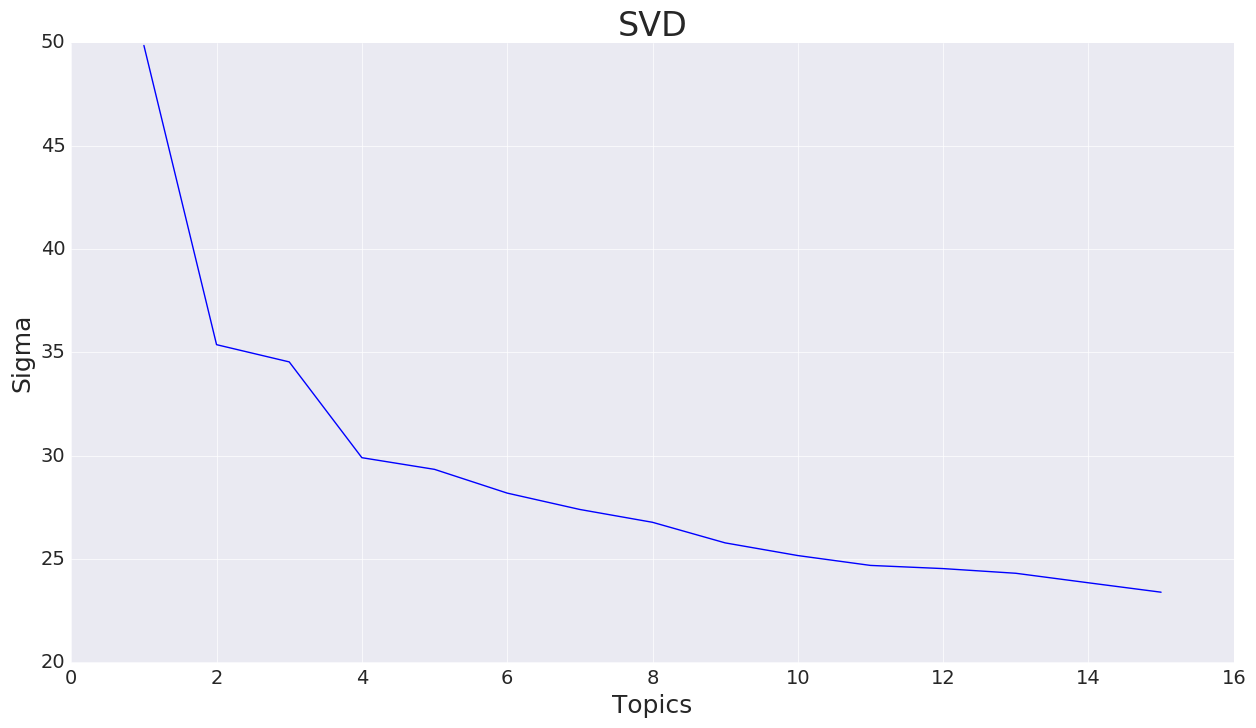

In [17]:
Sigma #5 topics is okay?
plt.figure(figsize=(15,8))
sns.set_style("darkgrid")
plt.plot(range(1,16), Sigma) # maybe 4 topics?
plt.title("SVD", fontsize = 24)
plt.xlabel("Topics", fontsize = 18)
plt.ylabel("Sigma", fontsize = 18)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.show()

In [18]:
nmf_model = NMF(n_components=3, init='random', random_state=0)

W = nmf_model.fit_transform(counts) ##do fit, and then transform? dtm_nmf = docs/topics

In [19]:
H = nmf_model.components_

In [20]:
H.shape

(3, 8707)

In [21]:
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        message = "Topic #%d: " % topic_idx
        message += " ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)
    print()

In [22]:
features = tf_idf_vectorizer.get_feature_names()

In [23]:
print_top_words(nmf_model, features, 15)

Topic #0: gun control laws orlando violence lasvegas parkland shooting sanbernardino stop america time guncontrol owners gunsense
Topic #1: 2a tcot pjnet trump ccot tgdn 1a trump2016 watch real teaparty mt nj2as rights molonlabe
Topic #2: guncontrol guns people guncontrolnow gunsense kill mass gunreformnow us gop right time one like shootings



In [24]:
nmf_model_nohtag = NMF(n_components=3, init='random', random_state=0)
W_nohtag = nmf_model_nohtag.fit_transform(counts_nohtag)
H_nohtag = nmf_model_nohtag.components_
features_nohtag = tf_idf_vectorizer_nohtag.get_feature_names()
print_top_words(nmf_model_nohtag, features_nohtag, 10)

Topic #0: gun control laws violence shooting nra time mass stop us
Topic #1: tcot trump pjnet 1a trump2016 watch ccot real tgdn teaparty
Topic #2: guns people kill right many us like one would problem



### TF IDF - Only Retain Discussion Tweets

In [60]:
df_discussion = df[df['cluster'] == 0]

In [61]:
tf_idf_vectorizer = TfidfVectorizer(stop_words=stop, max_df = 0.3, min_df = 25)
tf_idf_vectorizer.fit(df_discussion.tweet_nohashtag)
counts = tf_idf_vectorizer.transform(df_discussion.tweet_nohashtag)

In [62]:
U, Sigma, VT = randomized_svd(counts, n_components=15,
                                      n_iter=5,
                                      random_state=None)

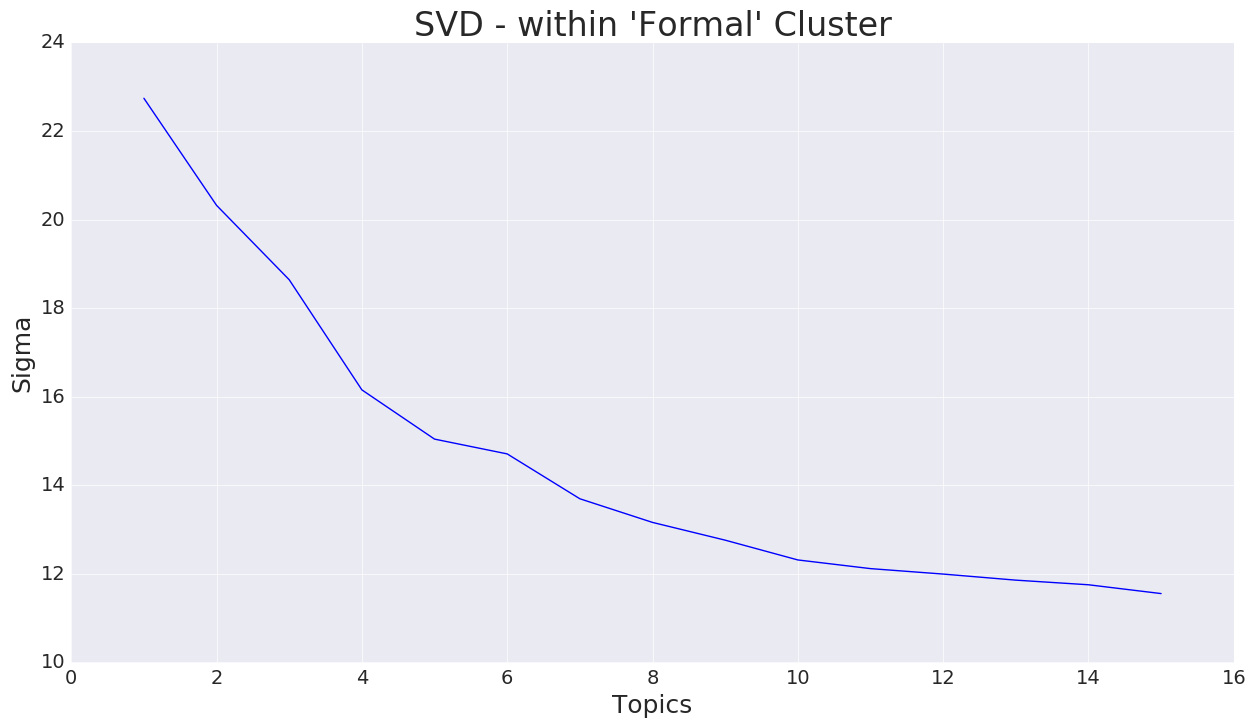

In [63]:
plt.figure(figsize=(15,8))
sns.set_style("darkgrid")
plt.plot(range(1,16), Sigma) # maybe 4 topics?
plt.title("SVD - within 'Formal' Cluster", fontsize = 24)
plt.xlabel("Topics", fontsize = 18)
plt.ylabel("Sigma", fontsize = 18)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.show()

In [64]:
nmf_model = NMF(n_components=3, init='random', random_state=0)

W = nmf_model.fit_transform(counts) ##do fit, and then transform? dtm_nmf = docs/topics

In [65]:
H = nmf_model.components_

In [66]:
features = tf_idf_vectorizer.get_feature_names()

In [67]:
print_top_words(nmf_model, features, 10)

Topic #0: laws violence america us shooting guns problem time would people
Topic #1: un obama stopatt grab stop violence guy treaty wont president
Topic #2: violence pledge voter candidates reduce fight commonsense vote laws end



In [68]:
clusters_discussion = []
for doc in W:
    clusters_discussion.append(doc.argmax())
df_discussion['cluster'] = clusters_discussion

In [77]:
df_discussion[df_discussion.cluster ==2].sort_values(by="retweets", ascending = False).reset_index(drop=True)[45:]

,ID,date,event,favorites,retweets,text,username,tweet,tweet_nohashtag,cluster
45,964156838915837952,2018-02-15 15:17:58,parkland,111,84,# Parkland # Democratsandguncontrol # GunControl # SchoolShootings Truth about Democrats and gun violence pic.twitter.com/uD6Vntc3Om,ETrumpgirl,Parkland Democratsandguncontrol GunControl SchoolShootings Truth about Democrats and gun violence,democratsandguncontrol schoolshootings truth about democrats and gun violence,2
46,379960989023621120,2013-09-17 13:32:13,navyyard,27,83,"Everyone who says we need better mental healthcare to reduce gun violence supports # Obamacare, right? http://psychcentral.com/news/2012/06/30/mental-health-care-benefits-under-affordable-care-act-obamacare/41052.html … # GOP # NRA # tcot",TheDailyEdge,Everyone who says we need better mental healthcare to reduce gun violence supports Obamacare right GOP NRA tcot,everyone who says we need better mental healthcare to reduce gun violence supports obamacare right gop tcot,2
47,743867073047068672,2016-06-17 18:05:05,orlando,169,77,"# DC: Led by gay PETA VP, mourning crowd brings animal heads to # NRA to protest gun violence. http://peta.vg/1r7v pic.twitter.com/ksjvi9kdLk",peta,DC Led by gay PETA VP mourning crowd brings animal heads to NRA to protest gun violence,dc led by gay peta vp mourning crowd brings animal heads to to protest gun violence,2
48,927973905888960512,2017-11-07 18:59:54,texaschurch,166,72,"This is what ""common-sense gun control"" looks like. # Hero # NRA # TuesdayThoughtspic.twitter.com/ttScRvnMxq",tweettruth2me,This is what commonsense gun control looks like Hero NRA TuesdayThoughts,this is what commonsense gun control looks like hero tuesdaythoughts,2
49,673205100211408896,2015-12-05 18:19:38,sanbernardino,2,71,End The INSANE Gun Epidemic In America http://nyti.ms/1SDQxIv # gunsense # TNTvote # TNTweeters # AINF # LibCrib # VoteOutGop # uniteblue # VOTE,hermanbutler1,End The INSANE Gun Epidemic In America gunsense TNTvote TNTweeters AINF LibCrib VoteOutGop uniteblue VOTE,end the insane gun epidemic in america tntvote tntweeters ainf libcrib voteoutgop uniteblue vote,2
50,673246286519357441,2015-12-05 21:03:17,sanbernardino,57,71,Chicago Gun violence is almost exclusively limited to the numerous nonwhite gangs http://newobserveronline.com/chicago-illegal-gun-found-every-74-mins/ … # 2A # NRApic.twitter.com/Ff4SGHxlge,Ann__Kelly,Chicago Gun violence is almost exclusively limited to the numerous nonwhite gangs 2A NRA,chicago gun violence is almost exclusively limited to the numerous nonwhite gangs,2
51,673246286519357441,2015-12-05 21:03:17,sanbernardino,57,71,Chicago Gun violence is almost exclusively limited to the numerous nonwhite gangs http://newobserveronline.com/chicago-illegal-gun-found-every-74-mins/ … # 2A # NRA pic.twitter.com/Ff4SGHxlge,Ann__Kelly,Chicago Gun violence is almost exclusively limited to the numerous nonwhite gangs 2A NRA,chicago gun violence is almost exclusively limited to the numerous nonwhite gangs,2
52,742141561333506048,2016-06-12 23:48:31,orlando,67,68,"The violence in # Orlando is far more American than it is ""Islamic extremism."" American gun violence is embedded and extreme.",KhaledBeydoun,The violence in Orlando is far more American than it is Islamic extremism American gun violence is embedded and extreme,the violence in is far more american than it is islamic extremism american gun violence is embedded and extreme,2
53,674255603091435521,2015-12-08 15:53:57,sanbernardino,50,65,Take the pledge for 2015: Our Promise ~ Retweet if you are in! # 2A # 2ADefenders # NRA # TrainHard # UnitedWeStandpic.twitter.com/H7WJpujjAC,AZWS,Take the pledge for 2015 Our Promise Retweet if you are in 2A 2ADefenders NRA TrainHard UnitedWeStand,take the pledge for 2015 our promise retweet if you are in 2adefenders trainhard unitedwestand,2
54,742783310552834048,2016-06-14 18:18:36,orlando,88,65,Moments of silence and no action to end gun violence is a mockery. # NoMoreSilence # Orlando # ImWi

In [46]:
df_discussion[df_discussion['tweet_nohashtag'].str.contains(" grab ")][['text', 'cluster', 'username', 'date']]

,text,cluster,username,date
39082,"Please start ur gun confiscation here in # Texas, that way we can put down ur unconstitutional gun grab quickly, saving the rest of the country the horrors of a civil war. # GunContolNow # GunControlNever # gunsense # floridaschoolshooting # floridahighschoolshooting # 2A # 2ndAmendment",1,hankthtank,2018-02-17 23:03:55
44505,Is # metoo movement proving that we west are probably not rape culture but are grab her by the ass or pussy culture # PATRIOTISM # americafirst # gunrights # lifestyle # selfesteem # capitalism,0,thebipolarbooks,2018-02-17 21:50:34
46658,"Criminals get a gun, usually illegally, load it and PULL the trigger all on their own. The gun does not grab your finger and force it to pull the trigger! We need to arm our teachers! # 2A # NRApic.twitter.com/HpKP6ygN7l",0,AngelLight2U,2018-02-15 18:26:00
48970,"Please start ur gun confiscation here in # Texas, that way we can put down ur unconstitutional gun grab quickly, saving the rest of the country the horrors of a civil war. # GunContolNow # GunControlNever # gunsense # floridaschoolshooting # floridahighschoolshooting # 2A # 2ndAmendment",1,hankthtank,2018-02-17 23:03:55
49121,"DEMOCRATS IGNORE OUR LAWS EVERY SINGLE DAY! Yet their first response after a shooting is to call for new gun laws?! This in and of itself shows you their real intentions. Their goal isn't to stop gun violence, it's to grab guns from law-abiding citizens. # 2A # MAGA Emma Gonzalezpic.twitter.com/wRWn0CuDea",1,INTJutsu,2018-02-17 21:37:59
49165,Makes as much sense as the left's gun grab. # 2ndAmendment # 2A # NRApic.twitter.com/giCCNvTIty,0,NCpatriot_ret50,2018-02-17 21:14:59
50461,"Well, here starts # MartinOMalley's run for the White House in 2020. He's only concerned about his 15 minutes of fame and a gun grab - just like all # Liberals. # 2A # 2ADefender # LiberalismIsASocialDiseasehttps://www.waynedupree.com/omalley-hits-a-new-low-gun-control/ …",0,cindievaccaro,2018-02-18 23:07:30
50501,We care about the kids ... unlike you abortion supporting leftists. Put cops in schools and end this gun grab. Because that what it is ... a GUN GRAB! # 2A,0,SweetFreedom29,2018-02-18 22:48:05
50771,Loony Leftist gun control groups are misleading America with the 18 school shooting number. It's all scare tactics to get liberals fired up to demand more gun control. Don't fall for the... False Flag Gun Grab # 2A # 2ndAmendment # NRA # FloridaShootingpic.twitter.com/CWyFleu76j,1,joeyyeo13,2018-02-18 20:13:19
51273,"Is this the son of @ fbi ? # FalseFlag tanother # Hitler gun grab feelings vs facts skit! # chicago go walk through that city and others without a gun! You’ll feel so safe! It’s a # GunFreeZone NOT! # 2A If you all were carrying, we wouldn’t have a problem https://apple.news/AfDFL-qlZTEuyT_FJAJhnzw …",1,2braptuedbyJC77,2018-02-18 16:14:20


### DUPLICATES BY CLUSTER

In [30]:
df.cluster.value_counts()

3    139971
0     46880
2     38264
1     24459
Name: cluster, dtype: int64

In [31]:
totalbycluster = df.groupby('cluster').count().tweet_nohashtag

In [32]:
duplicatesbycluster = df[df.tweet_nohashtag.duplicated()].groupby('cluster').count().tweet_nohashtag

In [33]:
duplicates = pd.DataFrame(duplicatesbycluster/totalbycluster).reset_index()
duplicates.rename(columns = {'tweet_nohashtag': 'Duplicate %'}, inplace = True)
duplicates.replace({0:'Gun Laws'}, inplace = True)
duplicates.replace({1:'Conservative'}, inplace = True)
duplicates.replace({2:'Informal'}, inplace=True)
duplicates.replace({3:'Anti NRA/GOP'}, inplace=True)

In [34]:
duplicates

,cluster,Duplicate %
0,Gun Laws,0.176493
1,Conservative,0.440002
2,Informal,0.166919
3,Anti NRA/GOP,0.142987


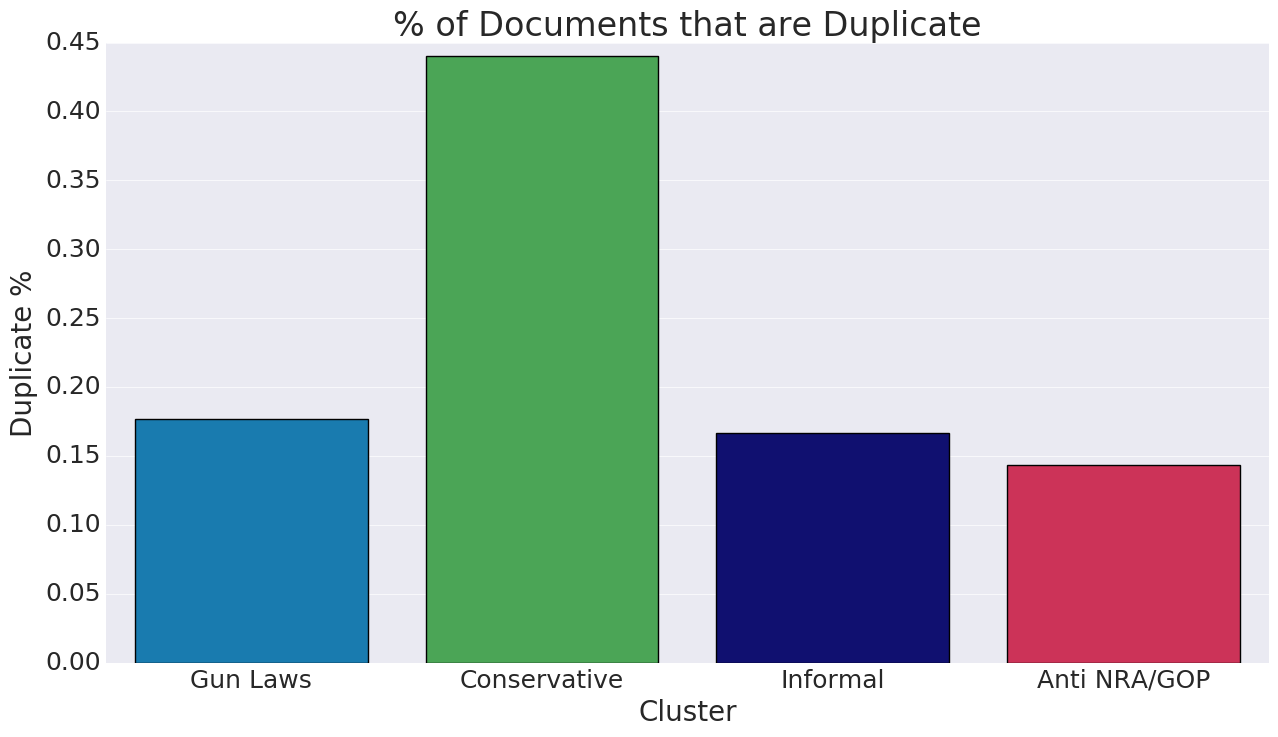

In [36]:
plt.figure(figsize=(15,8))
sns.set_style("darkgrid")
sns.barplot(x="cluster", y="Duplicate %", data=duplicates, palette = ["#0082c8", "#3cb44b", "#000080", "#e6194b"])
plt.title('% of Documents that are Duplicate', fontsize = 24)
plt.xticks(fontsize = 18)
plt.yticks(fontsize = 18)
plt.xlabel('Cluster', fontsize = 20)
plt.ylabel('Duplicate %', fontsize = 20)

Duplicates by Event

In [126]:
totalbycluster_event = df.groupby(['event', 'cluster'], as_index=False).count()
duplicatesbycluster_event = df[df.tweet_nohashtag.duplicated()].groupby(['event', 'cluster'], as_index = False).count()

In [135]:
duplicatesbyevent = totalbycluster_event[['event', 'cluster', 'ID']]
duplicatesbyevent.rename(columns = {'ID': 'TotalTweets'}, inplace = True)
duplicatesbyevent['Duplicate %'] = duplicatesbycluster_event['ID']/totalbycluster_event['ID']
duplicatesbyevent.replace({0:'formal'}, inplace = True)
duplicatesbyevent.replace({1:'trump/spam'}, inplace = True)
duplicatesbyevent.replace({2:'informal'}, inplace=True)
duplicatesbyevent.replace({3:'liberal'}, inplace=True)

In [47]:
df[df['tweet_nohashtag'].str.contains("and here we go with the crazy conspiracy")][['text', 'cluster', 'username']]

,text,cluster,username
219,and here we go with the crazy conspiracy theories @ Twitter or @ TwitterSupport need to stop this! # Florida # Parkland # GunControlNow # guncontrol https://twitter.com/Maureen723/status/963924277077725184 …,3,aliquid_haeret_
249,and here we go with the crazy conspiracy theories @ Twitter or @ TwitterSupport need to stop this! # Florida # Parkland # GunControlNow # guncontrol https://twitter.com/Maureen723/status/963923754647805952 …,3,aliquid_haeret_
10756,and here we go with the crazy conspiracy theories @ Twitter or @ TwitterSupport need to stop this! # Florida # Parkland # GunControlNow # guncontrolhttps://twitter.com/Maureen723/status/963924277077725184 …,3,aliquid_haeret_
10777,and here we go with the crazy conspiracy theories @ Twitter or @ TwitterSupport need to stop this! # Florida # Parkland # GunControlNow # guncontrolhttps://twitter.com/Maureen723/status/963923754647805952 …,3,aliquid_haeret_


In [35]:
df[df.tweet_nohashtag.duplicated()]

,ID,date,event,favorites,retweets,text,username,tweet,tweet_nohashtag,cluster
46,963925552162680832,2018-02-14 23:58:55,parkland,3,0,"And, remember, mass shooters are NOT domestic terrorists. ""You have people who are very fine people on both sides.” -Donald ""Shit For Brains"" Trump ""Parkland, Florida"" Columbine # GunControl",curtfloodjr,And remember mass shooters are NOT domestic terrorists You have people who are very fine people on both sides Donald Shit For Brains Trump Parkland Florida Columbine GunControl,and remember mass shooters are not domestic terrorists you have people who are very fine people on both sides donald shit for brains trump parkland florida columbine,2
249,963924355829981185,2018-02-14 23:54:09,parkland,0,1,and here we go with the crazy conspiracy theories @ Twitter or @ TwitterSupport need to stop this! # Florida # Parkland # GunControlNow # guncontrol https://twitter.com/Maureen723/status/963923754647805952 …,aliquid_haeret_,and here we go with the crazy conspiracy theories Twitter or TwitterSupport need to stop this Florida Parkland GunControlNow guncontrol,and here we go with the crazy conspiracy theories twitter or twittersupport need to stop this florida,3
471,963923136059191297,2018-02-14 23:49:19,parkland,1,0,"We need sensible # guncontrol!!! How many more incidents like this are going to be allowed before our law makers (who are supposed to serve their citizens) finally do their jobs??? At least 12 people, who were alive yesterday, are gone today because our lawmakers fail to act.",DJModel003,We need sensible guncontrol How many more incidents like this are going to be allowed before our law makers who are supposed to serve their citizens finally do their jobs At least 12 people who were alive yesterday are gone today because our lawmakers fail to act,we need sensible how many more incidents like this are going to be allowed before our law makers who are supposed to serve their citizens finally do their jobs at least 12 people who were alive yesterday are gone today because our lawmakers fail to act,3
558,963922568620232705,2018-02-14 23:47:03,parkland,5,0,"I’m pretty sure stricter # guncontrol would lead to fewer mass shootings. Go ahead, take the dare and enact # GunControlNow. Try to prove me wrong.",Answer_Claire,Im pretty sure stricter guncontrol would lead to fewer mass shootings Go ahead take the dare and enact GunControlNow Try to prove me wrong,im pretty sure stricter would lead to fewer mass shootings go ahead take the dare and enact try to prove me wrong,3
804,963921015276482561,2018-02-14 23:40:53,parkland,2,0,"We need sensible # guncontrol!!! How many more incidents like this are going to be allowed before our law makers (who are supposed to serve their citizens) finally do their jobs??? At least 12 people, who were alive yesterday, are gone today because our lawmakers fail to act.",DJModel003,We need sensible guncontrol How many more incidents like this are going to be allowed before our law makers who are supposed to serve their citizens finally do their jobs At least 12 people who were alive yesterday are gone today because our lawmakers fail to act,we need sensible how many more incidents like this are going to be allowed before our law makers who are supposed to serve their citizens finally do their jobs at least 12 people who were alive yesterday are gone today because our lawmakers fail to act,3
879,963920597154590720,2018-02-14 23:39:13,parkland,41,11,"A GOP rep is pushing for Shulkin's resignation for using tax money for his wife's vacation travel. I push for the resignation of all senators and reps for using NRA money to ensure that our safety ultimately lies at the mercy, sanity, and mood of gunowners. # GunControl",bonibrat,A GOP rep is pushing for Shulkins resignation for using tax money for his wifes vacation travel I push for the resignation of all senators and reps for using NRA money to ensure that our safety ultimately lies at the mercy sanity and mood of gunow

### BOKEH

In [25]:
import bokeh.plotting as bp
from bokeh.plotting import save
from bokeh.models import HoverTool

n_top_words = 5

In [26]:
colormap = np.array([
    "#0082c8", "#3cb44b", "#000080", "#e6194b"])

In [27]:
nmf_model_nohtag = NMF(n_components=4, init='random', random_state=0)
W_nohtag = nmf_model_nohtag.fit_transform(counts_nohtag)
H_nohtag = nmf_model_nohtag.components_

In [28]:
W_nohtag.shape

(249574, 4)

In [29]:
clusters_full = []
for doc in W_nohtag:
    clusters_full.append(doc.argmax())
df['cluster'] = clusters_full

In [33]:
threshold = 0.07
_idx = np.amax(W_nohtag, axis=1) > threshold  # idx of doc that above the threshold
topics = W_nohtag[_idx]
tweets = list(df.tweet_nohashtag[_idx])

In [34]:
clusters = []
for doc in topics:
    clusters.append(doc.argmax())

In [359]:
Counter(clusters)

Counter({0: 3027, 1: 4191, 2: 5738, 3: 2117})

In [99]:
tsne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='pca', perplexity = 40)
tsne_clust = tsne_model.fit_transform(topics)

[t-SNE] Computing pairwise distances...
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 1000 / 15073
[t-SNE] Computed conditional probabilities for sample 2000 / 15073
[t-SNE] Computed conditional probabilities for sample 3000 / 15073
[t-SNE] Computed conditional probabilities for sample 4000 / 15073
[t-SNE] Computed conditional probabilities for sample 5000 / 15073
[t-SNE] Computed conditional probabilities for sample 6000 / 15073
[t-SNE] Computed conditional probabilities for sample 7000 / 15073
[t-SNE] Computed conditional probabilities for sample 8000 / 15073
[t-SNE] Computed conditional probabilities for sample 9000 / 15073
[t-SNE] Computed conditional probabilities for sample 10000 / 15073
[t-SNE] Computed conditional probabilities for sample 11000 / 15073
[t-SNE] Computed conditional probabilities for sample 12000 / 15073
[t-SNE] Computed conditional probabilities for sample 13000 / 15073
[t-SNE] Computed conditional probabilities

In [100]:
topic_summaries = []
topic_word = nmf_model_nohtag.components_  # all topic words
vocab = tf_idf_vectorizer_nohtag.get_feature_names() # vocab
for i, topic_dist in enumerate(topic_word):
    topic_words = np.array(vocab)[np.argsort(topic_dist)][:-(n_top_words + 1):-1] # get top 5 words
    topic_summaries.append(' '.join(topic_words))

In [101]:
title = 'clusterviz2'
num_example = len(clusters)

plot_clust = bp.figure(plot_width=1000, plot_height=800,
                     title=title,
                     tools="pan,wheel_zoom,box_zoom,reset,hover,previewsave",
                     x_axis_type=None, y_axis_type=None, min_border=1)

plot_clust.scatter(x=tsne_clust[:, 0], y=tsne_clust[:, 1],
                 color=colormap[clusters][:num_example],
                 source=bp.ColumnDataSource({
                   "content": tweets,
                   "topic_key": clusters
                   }))

In [767]:
topic_coord = np.empty((topics.shape[1], 2)) * np.nan
for topic_num in clusters:
    if not np.isnan(topic_coord).any():
        break
    topic_coord[topic_num] = tsne_clust[clusters.index(topic_num)]

# plot crucial words
for i in range(topics.shape[1]):
    plot_clust.text(topic_coord[i, 0], topic_coord[i, 1], [topic_summaries[i]])

# hover tools
hover = plot_clust.select(dict(type=HoverTool))
hover.tooltips = {"content": "@content - topic: @topic_key"}

# save the plot
save(plot_clust, '{}.html'.format(title))

'/home/kstern/Fletcher/clusterviz2.html'

In [361]:
df.cluster.value_counts()

3    139971
0     46880
2     38264
1     24459
Name: cluster, dtype: int64

In [ ]:
df[df['tweet_nohashtag'].str.contains("maga")][['text', 'cluster', 'username']]

### BOKEH - Diff Weighting Scheme

In [92]:
colormap = np.array([
    "#0082c8", "#3cb44b", "#000080", "#e6194b"])

In [93]:
nmf_model_nohtag = NMF(n_components=4, init='random', random_state=0)
W_nohtag = nmf_model_nohtag.fit_transform(counts_nohtag)
H_nohtag = nmf_model_nohtag.components_

In [217]:
df.tweet_nohashtag[6]

'my prayers go out my heart goes out sending my love action is what is required not your false compassion  florida '

In [219]:
W_nohtag[6]

array([ 0.        ,  0.        ,  0.        ,  0.03576295])

In [95]:
clusters_full = []
for doc in W_nohtag:
    clusters_full.append(doc.argmax())
df['cluster'] = clusters_full

In [220]:
(maxW/sumW)[6]

1.0

In [185]:
threshold = 0.99999999999999
maxW = np.amax(W_nohtag,axis = 1)
sumW = np.sum(W_nohtag, axis = 1)
_idx = maxW/sumW > threshold  # idx of doc that above the threshold
topics = W_nohtag[_idx]
tweets = list(df.tweet_nohashtag[_idx])

In [186]:
len(tweets)

22567

In [188]:
clusters = []
for doc in topics:
    clusters.append(doc.argmax())

In [189]:
Counter(clusters)

Counter({0: 3126, 1: 1284, 2: 2157, 3: 16000})

In [190]:
tsne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='pca', perplexity = 40)
tsne_clust = tsne_model.fit_transform(topics)

[t-SNE] Computing pairwise distances...
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 1000 / 22567
[t-SNE] Computed conditional probabilities for sample 2000 / 22567
[t-SNE] Computed conditional probabilities for sample 3000 / 22567
[t-SNE] Computed conditional probabilities for sample 4000 / 22567
[t-SNE] Computed conditional probabilities for sample 5000 / 22567
[t-SNE] Computed conditional probabilities for sample 6000 / 22567
[t-SNE] Computed conditional probabilities for sample 7000 / 22567
[t-SNE] Computed conditional probabilities for sample 8000 / 22567
[t-SNE] Computed conditional probabilities for sample 9000 / 22567
[t-SNE] Computed conditional probabilities for sample 10000 / 22567
[t-SNE] Computed conditional probabilities for sample 11000 / 22567
[t-SNE] Computed conditional probabilities for sample 12000 / 22567
[t-SNE] Computed conditional probabilities for sample 13000 / 22567
[t-SNE] Computed conditional probabilities

In [191]:
topic_summaries = []
topic_word = nmf_model_nohtag.components_  # all topic words
vocab = tf_idf_vectorizer_nohtag.get_feature_names() # vocab
for i, topic_dist in enumerate(topic_word):
    topic_words = np.array(vocab)[np.argsort(topic_dist)][:-(n_top_words + 1):-1] # get top 5 words
    topic_summaries.append(' '.join(topic_words))

In [192]:
title = 'clusterviz_weightv2'
num_example = len(clusters)

plot_clust = bp.figure(plot_width=1000, plot_height=800,
                     title=title,
                     tools="pan,wheel_zoom,box_zoom,reset,hover,previewsave",
                     x_axis_type=None, y_axis_type=None, min_border=1)

plot_clust.scatter(x=tsne_clust[:, 0], y=tsne_clust[:, 1],
                 color=colormap[clusters][:num_example],
                 source=bp.ColumnDataSource({
                   "content": tweets,
                   "topic_key": clusters
                   }))

In [193]:
topic_coord = np.empty((topics.shape[1], 2)) * np.nan
for topic_num in clusters:
    if not np.isnan(topic_coord).any():
        break
    topic_coord[topic_num] = tsne_clust[clusters.index(topic_num)]

# plot crucial words
for i in range(topics.shape[1]):
    plot_clust.text(topic_coord[i, 0], topic_coord[i, 1], [topic_summaries[i]])

# hover tools
hover = plot_clust.select(dict(type=HoverTool))
hover.tooltips = {"content": "@content - topic: @topic_key"}

# save the plot
save(plot_clust, '{}.html'.format(title))

'/home/kstern/Fletcher/clusterviz_weightv2.html'

In [768]:
df.cluster.value_counts()

3    139971
0     46880
2     38264
1     24459
Name: cluster, dtype: int64

In [ ]:
df[df['tweet_nohashtag'].str.contains("maga")][['text', 'cluster', 'username']]

## Topic Evolution by Event

In [48]:
topicbyevent = df.groupby(['event', 'cluster'], as_index=False).count()[['event', 'cluster', 'ID']]
topicbyevent.rename(columns = {'ID': 'Count'}, inplace = True)
topicbyevent.replace({0:'Gun Laws'}, inplace = True)
topicbyevent.replace({1:'Conservative'}, inplace = True)
topicbyevent.replace({2:'Informal'}, inplace=True)
topicbyevent.replace({3:'Anti NRA/GOP'}, inplace=True)

In [49]:
aurora = topicbyevent[topicbyevent['event']=='aurora']
aurora['percent'] = aurora['Count'] / aurora.Count.sum()
lasvegas = topicbyevent[topicbyevent['event']=='lasvegas']
lasvegas['percent'] = lasvegas['Count'] / lasvegas.Count.sum()
navyyard = topicbyevent[topicbyevent['event']=='navyyard']
navyyard['percent'] = navyyard['Count'] / navyyard.Count.sum()
orlando = topicbyevent[topicbyevent['event']=='orlando']
orlando['percent'] = orlando['Count'] / orlando.Count.sum()
parkland = topicbyevent[topicbyevent['event']=='parkland']
parkland['percent'] = parkland['Count'] / parkland.Count.sum()
sanbernardino = topicbyevent[topicbyevent['event']=='sanbernardino']
sanbernardino['percent'] = sanbernardino['Count'] / sanbernardino.Count.sum()
sandyhook = topicbyevent[topicbyevent['event']=='sandyhook']
sandyhook['percent'] = sandyhook['Count'] / sandyhook.Count.sum()
texaschurch = topicbyevent[topicbyevent['event']=='texaschurch']
texaschurch['percent'] = texaschurch['Count'] / texaschurch.Count.sum()

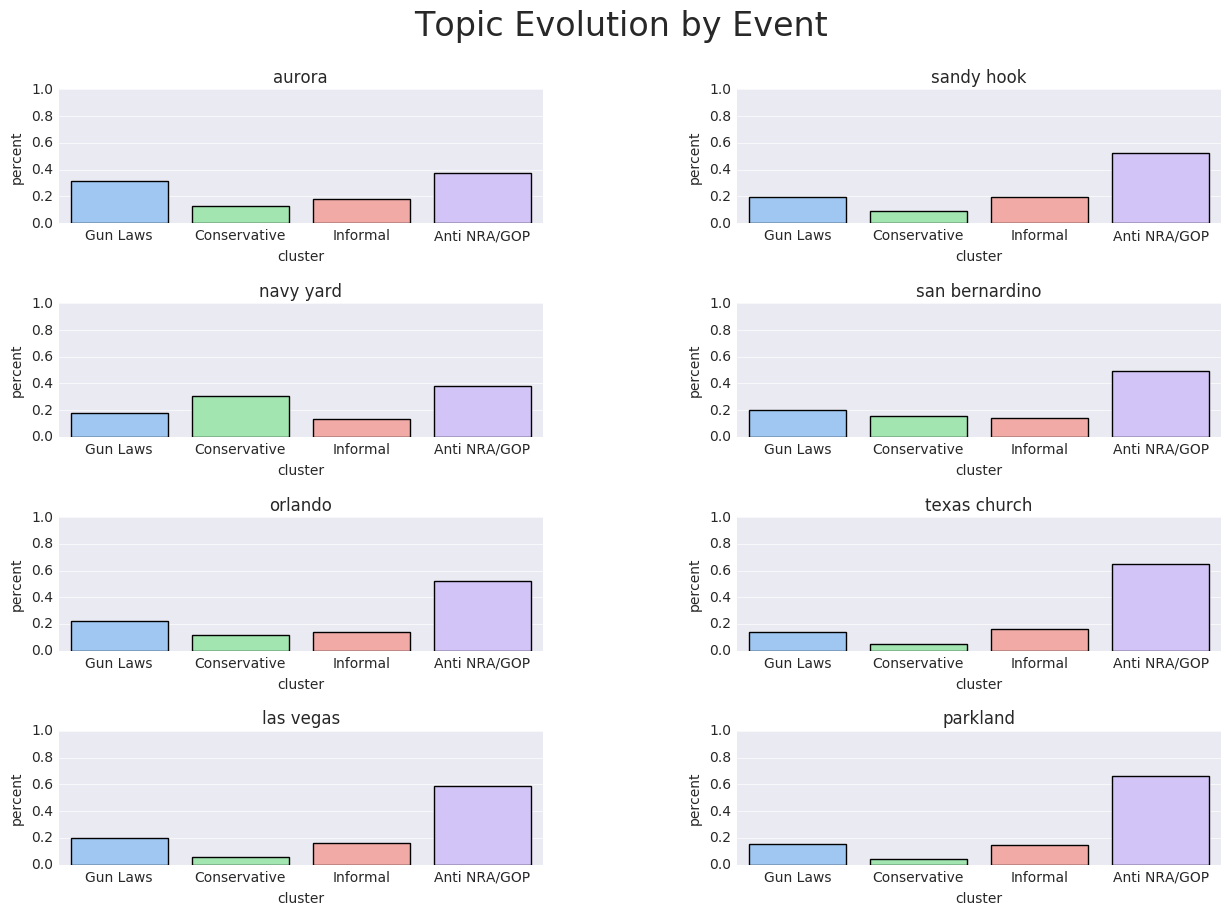

In [50]:
fig, axs = plt.subplots(nrows=4,ncols=2)
fig.set_size_inches(15, 10)
plt.subplots_adjust(hspace=0.6, wspace=0.4)
sns.set_style("darkgrid")
for i in range(0,4):
    for j in range(0,2):
        axs[i][j].set_ylim(0,1)
sns.barplot(x="cluster", y="percent", data=aurora, palette = 'pastel', ax = axs[0][0]).set_title('aurora')
sns.barplot(x="cluster", y="percent", data=sandyhook, palette = 'pastel', ax = axs[0][1]).set_title('sandy hook')
sns.barplot(x="cluster", y="percent", data=navyyard, palette = 'pastel', ax = axs[1][0]).set_title('navy yard')
sns.barplot(x="cluster", y="percent", data=sanbernardino, palette = 'pastel', ax = axs[1][1]).set_title('san bernardino')
sns.barplot(x="cluster", y="percent", data=orlando, palette = 'pastel', ax = axs[2][0]).set_title('orlando')
sns.barplot(x="cluster", y="percent", data=texaschurch, palette = 'pastel', ax = axs[2][1]).set_title('texas church')
sns.barplot(x="cluster", y="percent", data=lasvegas, palette = 'pastel', ax = axs[3][0]).set_title('las vegas')
sns.barplot(x="cluster", y="percent", data=parkland, palette = 'pastel', ax = axs[3][1]).set_title('parkland')
fig.suptitle("Topic Evolution by Event", fontsize = 24)



## Bokeh - Diff Num Topics

In [77]:
nmf_model_nohtag = NMF(n_components=3, init='random', random_state=0)
W_nohtag = nmf_model_nohtag.fit_transform(counts_nohtag)
H_nohtag = nmf_model_nohtag.components_
features_nohtag = tf_idf_vectorizer_nohtag.get_feature_names()
print_top_words(nmf_model_nohtag, features_nohtag, 10)

Topic #0: gun control laws violence shooting nra time mass stop us
Topic #1: tcot trump pjnet 1a trump2016 watch ccot real tgdn teaparty
Topic #2: guns people kill right many us like one would problem



In [78]:
n_top_words = 5

In [79]:
colormap = np.array([
    "#0082c8", "#3cb44b", "#000080", "#e6194b", "#ff99ff"])

In [80]:
W_nohtag.shape

(249574, 3)

In [81]:
df_clusters = []
for doc in W_nohtag:
    df_clusters.append(doc.argmax())
df['cluster'] = df_clusters

In [82]:
threshold = 0.08 #can do 0.065 to get max # tweets
_idx = np.amax(W_nohtag, axis=1) > threshold  # idx of doc that above the threshold
topics = W_nohtag[_idx]
tweets = list(df.tweet_nohashtag[_idx])

In [83]:
len(tweets)

7560

In [84]:
tsne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='pca', perplexity = 40)
tsne_clust = tsne_model.fit_transform(topics)

[t-SNE] Computing pairwise distances...
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 1000 / 7560
[t-SNE] Computed conditional probabilities for sample 2000 / 7560
[t-SNE] Computed conditional probabilities for sample 3000 / 7560
[t-SNE] Computed conditional probabilities for sample 4000 / 7560
[t-SNE] Computed conditional probabilities for sample 5000 / 7560
[t-SNE] Computed conditional probabilities for sample 6000 / 7560
[t-SNE] Computed conditional probabilities for sample 7000 / 7560
[t-SNE] Computed conditional probabilities for sample 7560 / 7560
[t-SNE] Mean sigma: 0.000000
[t-SNE] Error after 100 iterations with early exaggeration: 1.097649
[t-SNE] Error after 300 iterations: 1.022988


In [85]:
clusters = []
for doc in topics:
    clusters.append(doc.argmax())

In [86]:
Counter(clusters)

Counter({0: 513, 1: 3024, 2: 4023})

In [87]:
topic_summaries = []
topic_word = nmf_model_nohtag.components_  # all topic words
vocab = tf_idf_vectorizer_nohtag.get_feature_names() # vocab
for i, topic_dist in enumerate(topic_word):
    topic_words = np.array(vocab)[np.argsort(topic_dist)][:-(n_top_words + 1):-1] # get top 5 words
    topic_summaries.append(' '.join(topic_words))

In [88]:
title = 'clusterviz3topics_higherthreshold'
num_example = len(clusters)

plot_clust = bp.figure(plot_width=1000, plot_height=800,
                     title=title,
                     tools="pan,wheel_zoom,box_zoom,reset,hover,previewsave",
                     x_axis_type=None, y_axis_type=None, min_border=1)

plot_clust.scatter(x=tsne_clust[:, 0], y=tsne_clust[:, 1],
                 color=colormap[clusters][:num_example],
                 source=bp.ColumnDataSource({
                   "content": tweets,
                   "topic_key": clusters
                   }))

In [89]:
topic_coord = np.empty((topics.shape[1], 2)) * np.nan
for topic_num in clusters:
    if not np.isnan(topic_coord).any():
        break
    topic_coord[topic_num] = tsne_clust[clusters.index(topic_num)]

# plot crucial words
for i in range(topics.shape[1]):
    plot_clust.text(topic_coord[i, 0], topic_coord[i, 1], [topic_summaries[i]])

# hover tools
hover = plot_clust.select(dict(type=HoverTool))
hover.tooltips = {"content": "@content - topic: @topic_key"}

# save the plot
save(plot_clust, '{}.html'.format(title))

'/home/kstern/Fletcher/clusterviz3topics_higherthreshold.html'

### Clustering

All Clustering methods seem to give extremely unbalanced clusters, or they cluster all tweets into one cluster.


In [206]:
clusters = []
for doc in W:
    clusters.append(doc.argmax())
df['cluster'] = clusters

cluster_nohtag = []
for doc in W_nohtag:
    cluster_nohtag.append(doc.argmax())
df['cluster_nohtag'] = cluster_nohtag

/home/kstern/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/kstern/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [114]:
dbscan = DBSCAN(eps=0.01, metric = 'cosine' , algorithm='brute', min_samples = 3)
fit = dbscan.fit(W)
fit.labels_

array([0, 0, 0, ..., 0, 0, 0])

In [121]:
df['clusters'] = fit.labels_

In [122]:
df.clusters.value_counts()

0    48325
1     1670
Name: clusters, dtype: int64

## WORD2VEC

In [725]:
documents = df.tweet_nohashtag

In [726]:
texts = [[word for word in document.lower().split() if word not in stop]
         for document in documents]

In [727]:
model = gensim.models.Word2Vec(texts, size=100, window=20, min_count=1000, workers=2,sg=1)

INFO:gensim.models.word2vec:collecting all words and their counts
INFO:gensim.models.word2vec:PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO:gensim.models.word2vec:PROGRESS: at sentence #10000, processed 153120 words, keeping 18701 word types
INFO:gensim.models.word2vec:PROGRESS: at sentence #20000, processed 302388 words, keeping 26544 word types
INFO:gensim.models.word2vec:PROGRESS: at sentence #30000, processed 450832 words, keeping 32485 word types
INFO:gensim.models.word2vec:PROGRESS: at sentence #40000, processed 600905 words, keeping 38731 word types
INFO:gensim.models.word2vec:PROGRESS: at sentence #50000, processed 760321 words, keeping 45141 word types
INFO:gensim.models.word2vec:PROGRESS: at sentence #60000, processed 930169 words, keeping 50228 word types
INFO:gensim.models.word2vec:PROGRESS: at sentence #70000, processed 1045540 words, keeping 54725 word types
INFO:gensim.models.word2vec:PROGRESS: at sentence #80000, processed 1155682 words, keeping

In [731]:
model.most_similar('trump', topn = 8)

[('trump2016', 0.7948797941207886),
 ('real', 0.7014662623405457),
 ('1a', 0.6769379377365112),
 ('realdonaldtrump', 0.6634072661399841),
 ('1', 0.6532963514328003),
 ('maga', 0.6208459734916687),
 ('watch', 0.5927828550338745),
 ('foxnews', 0.4965195953845978)]

In [729]:
def tsne_plot(model):
    "Creates and TSNE model and plots it"
    labels = []
    tokens = []

    for word in model.wv.vocab:
        tokens.append(model[word])
        labels.append(word)
    
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=42)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(16, 16)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()

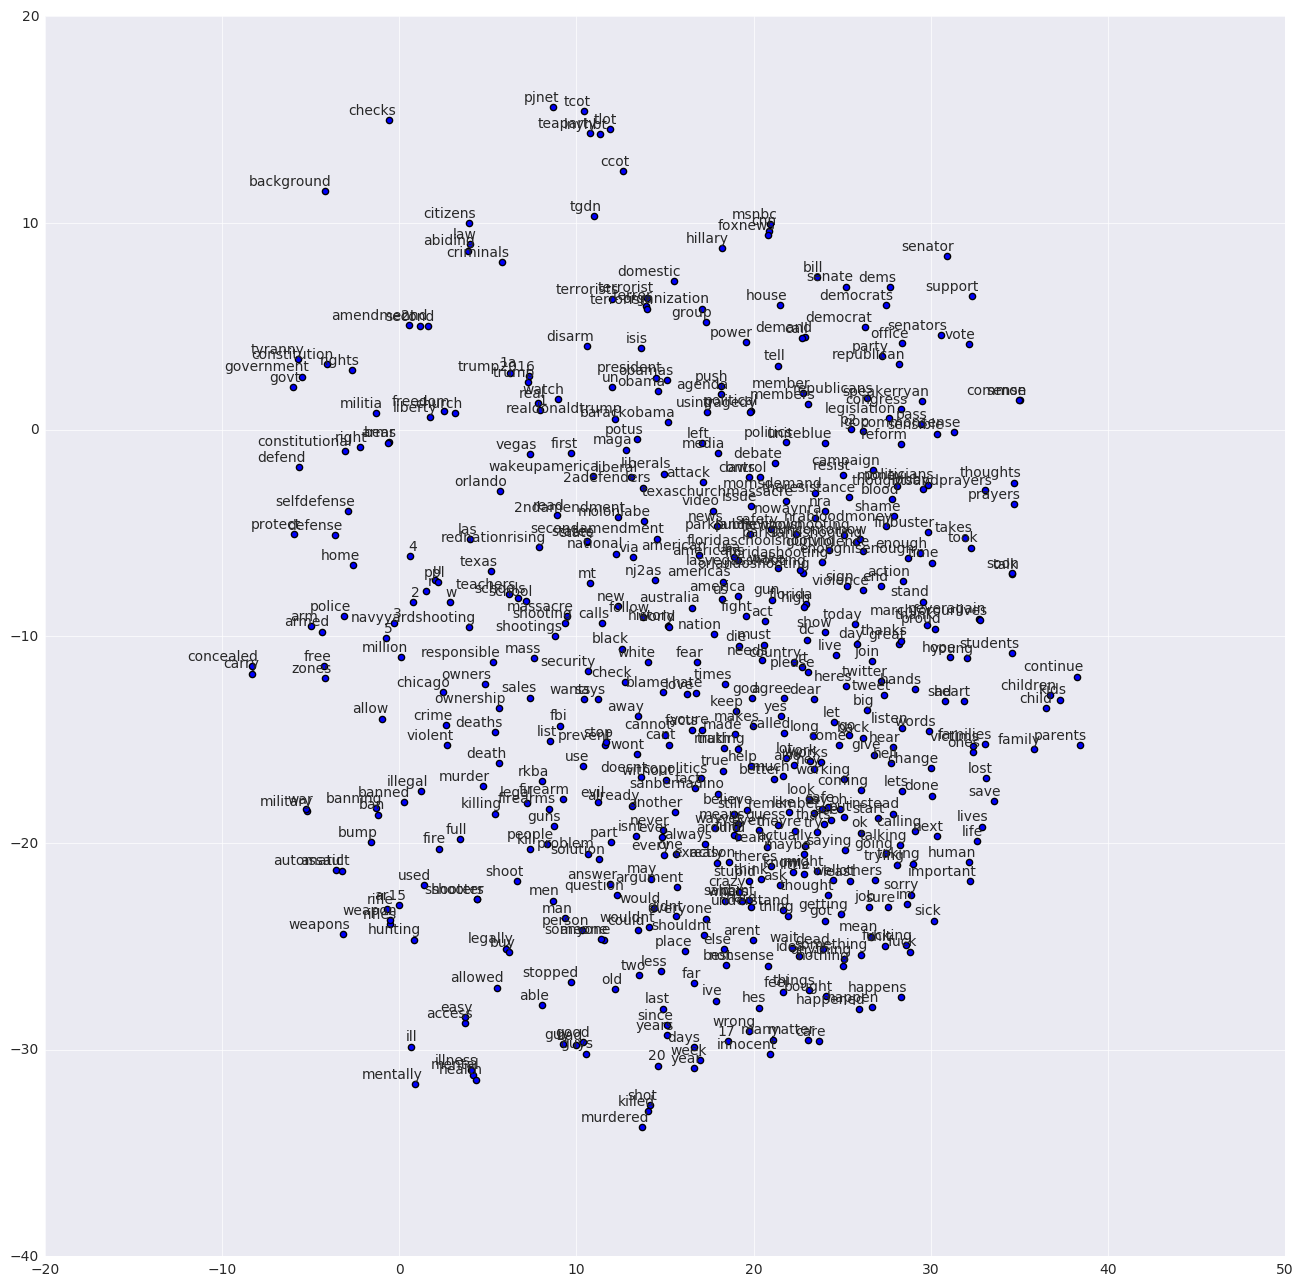

In [730]:
tsne_plot(model)

## DOC2VEC

In [436]:
from gensim.models.doc2vec import TaggedDocument, Doc2Vec
from collections import namedtuple

In [437]:
documents = list(df.tweet)
texts = [[word for word in document.lower().split() if word not in stop]
         for document in documents]

In [438]:
docs = []
analyzedDocument = namedtuple('AnalyzedDocument', 'words tags')
for i, text in enumerate(documents):
    words = text.lower().split()
    tags = [i]
    docs.append(analyzedDocument(words, tags))

In [439]:
model = gensim.models.Doc2Vec(docs, dm = 0, size= 1000, min_count = 1)

In [440]:
tokens = texts[0]
new_vector = model.infer_vector(tokens)
model.docvecs.most_similar([new_vector])

[(18560, 0.9643814563751221),
 (71546, 0.9631319046020508),
 (10999, 0.9627978801727295),
 (47917, 0.9625858068466187),
 (47807, 0.9623581171035767),
 (47874, 0.9621952176094055),
 (31289, 0.9619534015655518),
 (2653, 0.9617915153503418),
 (30444, 0.9613116383552551),
 (42712, 0.9611743688583374)]

In [441]:
documents[0]

'Another school shooting  your thoughts  prayers are still meaningless We demand action on common sense  guncontrol'

In [445]:
documents[71546]

' Trump  MAGA  JoeBiden  GunControl  MentalIllness  MentalHealth  Connecticut  DC  Dems  DNC  GOP  Portland  Moms  Dads  Denver  Vegas  Seattle  Ohio  Iowa  Pennsylvania  cnn  msnbc  cbsn  nfl  LA  nba  Texas  tcot  ccot  SC  Congress  Senate  News  KC  Christians  USA'

In [446]:
df.text[71546]

"Why isn't he giving these jobs to his # MAGA Cult? Oh yes, they want a living wage! # SanAntonio # SundayThoughts Texas # GunControl https://twitter.com/kylegriffin1/status/926917116900474885 …"

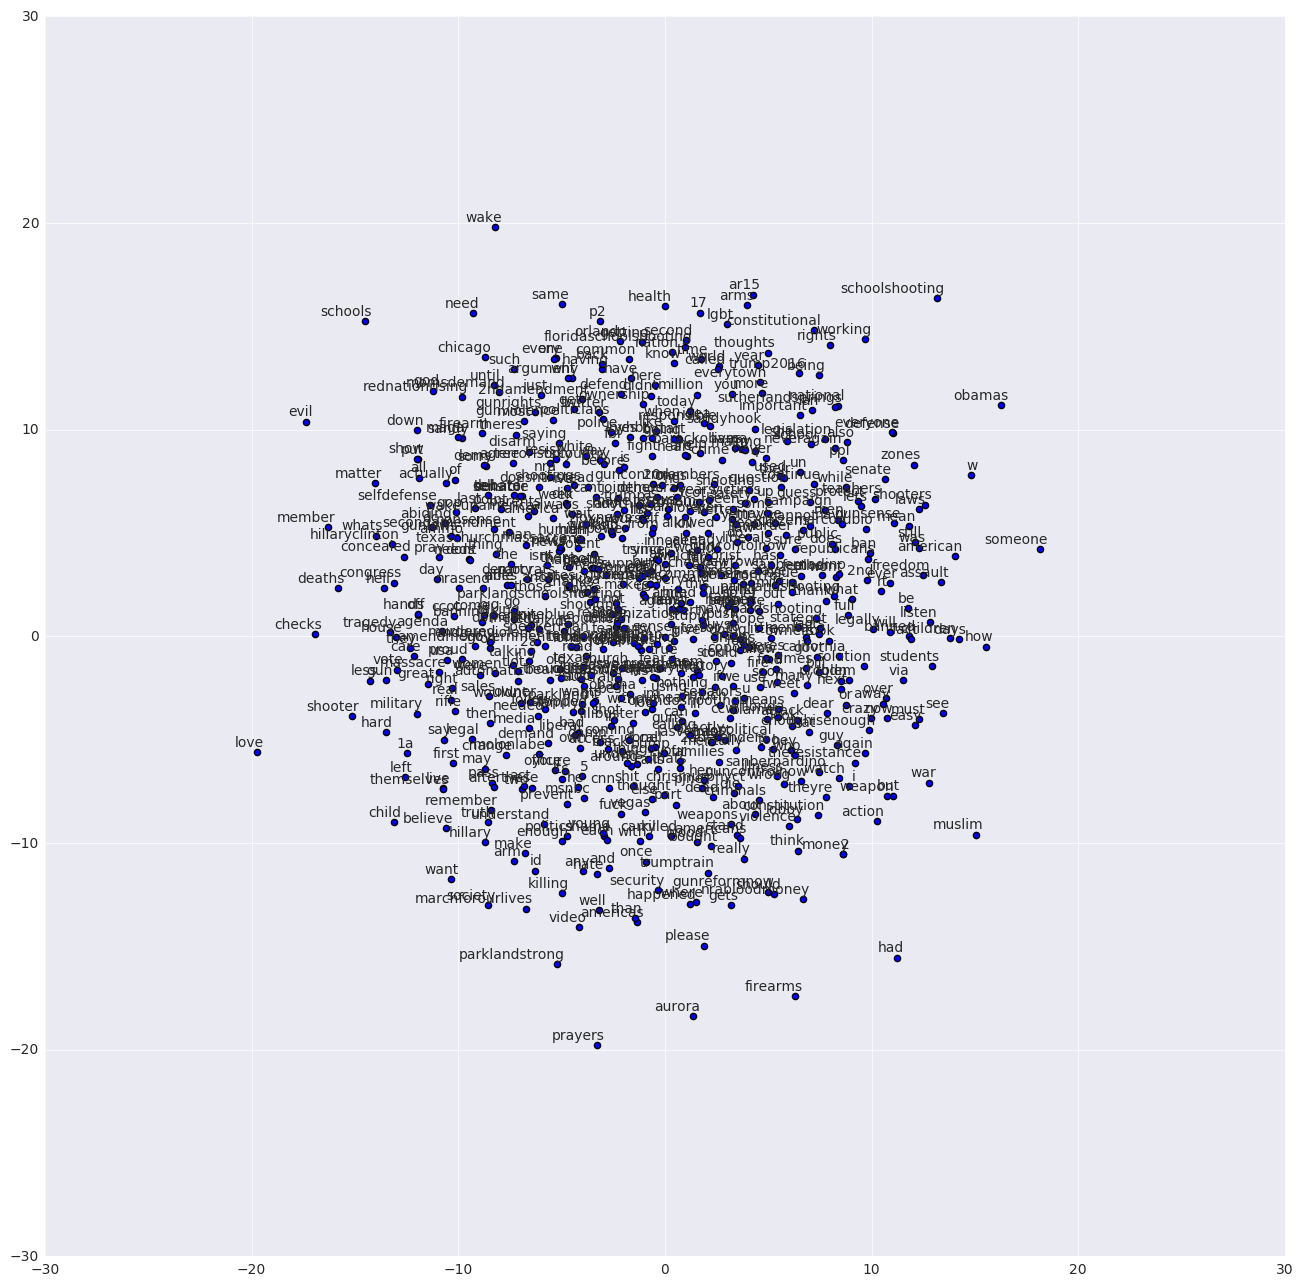

In [242]:
tsne_plot(model)

### TESTING

In [ ]:
from nltk.tokenize import sent_tokenize

In [12]:
df.loc[100,'text']

'This is sick and cannot be tolerated # GunControl https://twitter.com/HuffPost/status/963924593370128384 …'

In [13]:
text = df.loc[0,'text']
sentences = sent_tokenize(text)
print(sentences)

['Another school shooting & your "thoughts & prayers" are still meaningless.', 'We demand action on common sense # guncontrol.']


In [14]:
from nltk.tokenize import word_tokenize
words = word_tokenize(sentences[1])
words

['We', 'demand', 'action', 'on', 'common', 'sense', '#', 'guncontrol', '.']

In [15]:
from nltk.tag import pos_tag
words=pos_tag(word_tokenize(sentences[1]))
words

[('We', 'PRP'),
 ('demand', 'VBP'),
 ('action', 'NN'),
 ('on', 'IN'),
 ('common', 'JJ'),
 ('sense', 'NN'),
 ('#', '#'),
 ('guncontrol', 'NN'),
 ('.', '.')]

In [16]:
from nltk.chunk import ne_chunk
words = word_tokenize(sentences[1])
tags = pos_tag(words)
tree = ne_chunk(tags)
print(tags)
print(tree)

[('We', 'PRP'), ('demand', 'VBP'), ('action', 'NN'), ('on', 'IN'), ('common', 'JJ'), ('sense', 'NN'), ('#', '#'), ('guncontrol', 'NN'), ('.', '.')]
(S
  We/PRP
  demand/VBP
  action/NN
  on/IN
  common/JJ
  sense/NN
  #/#
  guncontrol/NN
  ./.)


In [17]:
from textblob import TextBlob

sentence = df.loc[0,'text']

blob = TextBlob(sentence)
print(blob)

Another school shooting & your "thoughts & prayers" are still meaningless. We demand action on common sense # guncontrol.


In [18]:
blob.tags

[('Another', 'DT'),
 ('school', 'NN'),
 ('shooting', 'VBG'),
 ('&', 'CC'),
 ('your', 'PRP$'),
 ('thoughts', 'NNS'),
 ('&', 'CC'),
 ('prayers', 'NNS'),
 ('are', 'VBP'),
 ('still', 'RB'),
 ('meaningless', 'RB'),
 ('We', 'PRP'),
 ('demand', 'VBP'),
 ('action', 'NN'),
 ('on', 'IN'),
 ('common', 'JJ'),
 ('sense', 'NN'),
 ('guncontrol', 'NN')]

In [19]:
blob.sentiment

Sentiment(polarity=-0.2333333333333333, subjectivity=0.5333333333333333)

In [20]:
lemma = nltk.stem.WordNetLemmatizer()

for word in blob.words:
    print(lemma.lemmatize(word))

Another
school
shooting
your
thought
prayer
are
still
meaningless
We
demand
action
on
common
sense
guncontrol


In [21]:
from nltk.util import ngrams

from operator import itemgetter
from nltk.corpus import stopwords
import re

In [22]:
stop = stopwords.words('english')
stop += ['.', ',', '(',')', "'", '"']
stop=set(stop)

In [23]:
corpus = list(df.text)

In [24]:
counter = Counter()

In [38]:
counter = Counter()
test = corpus[36]
words = TextBlob(test).words
words = [w for w in words if w not in stop]
bigrams = ngrams(words,2)
counter += Counter(bigrams)

for phrase,count in counter.most_common():
    print('%20s %i' % (" ".join(phrase),count))

         hear tragic 1
        tragic event 1
   affected involved 1
     victims prayers 1
guncontrol FloridaSchoolShootingpic.twitter.com/URLvOXVu25 1
          Prayers go 1
       group Prayers 1
    victims affected 1
    event especially 1
            sad hear 1
       Ash Wednesday 1
           safe keep 1
           age group 1
          start Lent 1
         victims age 1
            At start 1
       involved Stay 1
  especially victims 1
    families victims 1
            Lent sad 1
        keep victims 1
           Stay safe 1
Wednesday guncontrol 1
         prayers Ash 1
         go families 1


In [39]:
counter = Counter()

In [40]:
n =2
for doc in corpus[:1000]:
    words = TextBlob(doc).words
    words = [w for w in words if w not in stop]
    bigrams = ngrams(words,n)
    counter+= Counter(bigrams)
    
for phrase,count in counter.most_common(30):
    print('%20s %i' % (" ".join(phrase),count))

     school shooting 55
GunControlNow guncontrol 52
    thoughts prayers 45
    guncontrol https 44
         gun control 42
    Parkland Florida 37
             We need 35
    school shootings 34
guncontrol GunControlNow 34
       mass shooting 33
            How many 30
               It 's 24
                I 'm 24
        Nicolas Cruz 22
      mass shootings 21
             The NRA 21
  Florida guncontrol 19
        gun violence 19
     talk guncontrol 19
         kill people 18
            gun laws 18
           time talk 18
guncontrol guncontrol 17
    GunControl https 16
    Florida Parkland 16
        common sense 16
GunControl GunControlNow 15
 Parkland guncontrol 15
  guncontrol Florida 15
              ca n't 15


## NICE TO HAVE

In [44]:
translator = Translator()
x = translator.detect(df.tweet.loc[5])
x.lang #to find language of tweet
translator.translate(df.tweet.loc[5]).text #get translated text

'# 14February These are the Friends of @ SalvadorAlianza and @ manuelzr they support it by generating hate, violence and destruction in our # Honduras @ EnAlianza @ bbcmundo @ AFP @ AP_Noticias # guncontrol # OTDirecto14F # AlianzaDelMal # AlianzaSALVAtrucha @ RoyCampos @ grazianodasilva @ CNNEE'